In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
# importing Qiskit
import qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit import transpile
from scipy import optimize


provider = IBMQ.load_account()

print(qiskit.__qiskit_version__)

ibmqfactory.load_account:WARNING:2023-01-29 17:52:36,496: Credentials are already in use. The existing account in the session will be replaced.


{'qiskit-terra': '0.22.3', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.4', 'qiskit-nature': '0.5.2', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [4]:
# Generating the butterfly graph with 5 nodes 
n     = 5
V     = np.arange(0,n,1)
#E     =[(1,2,1.0),(2,3,1.0),(4,3,1.0),(4,2,1.0),(0,4,1.0)] 
#E = [(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,4,1.0),(4,5,1.0),(5,0,1.0)]

#G     = nx.Graph()
#G.add_nodes_from(V)
#G.add_weighted_edges_from(E)

#Generate random regular graph
G = nx.random_regular_graph(3,6)

#G = nx.gnp_random_graph(7, 0.4)

# Generate plot of the Graph

colors       = ['dodgerblue' for node in G.nodes()]
pos          = nx.spring_layout(G)
nx.set_edge_attributes(G, 1, 'weight')
edge_labels = nx.get_edge_attributes(G, "weight")
pos = nx.spring_layout(G, k=1)
nx.draw_networkx(G, node_color=colors, node_size=400, alpha=1, pos=pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels)


{(1, 2): Text(-0.5928374613204428, 0.008468258276075634, '1'),
 (1, 5): Text(-0.7267258970856829, -0.3912191792189272, '1'),
 (1, 4): Text(-0.4698117011515535, 0.43700284084042884, '1'),
 (2, 3): Text(0.36452638626336253, 0.19584540508739928, '1'),
 (2, 5): Text(-0.3195633584061257, -0.5001593753122391, '1'),
 (0, 4): Text(0.36219951082232055, 0.19537377413152798, '1'),
 (0, 3): Text(0.7893750595576794, 0.0631565344718103, '1'),
 (0, 5): Text(0.1052853148881911, -0.6328482459278281, '1'),
 (4, 3): Text(0.48755214643225175, 0.6243799876517525, '1')}

In [5]:
def QAOA_circuit(γ,β,G):  
    
    # Returns an appropriate quantum circuit mapping p blocks (length of γ,β) 
    #of evolution according to the cost Hamiltonian induced by graph G
    
    # Create the |+> state on every qubit 
    QAOA=QuantumCircuit(len(G.nodes()),len(G.nodes()))
    QAOA.h(range(len(G.nodes())))
    #to prevent unwanted transpiling optimization
    QAOA.barrier()
    

    for i in range(γ.size): #exp(-i*γ*H_c) repeated with different angles γ for each block
        for edge in G.edges():
            k = edge[0]
            l = edge[1]
            QAOA.rzz(2*γ[i], k, l)
    
    # then apply the single qubit X - rotations with angle β to all qubits (exp(-i*β*H_b))
        QAOA.barrier()
        #rotation gates do only half a turn! Have a look at qiskit documentation
        #minus is incorported
        QAOA.rx(-2*β[i], range(len(G.nodes())))

    # Finally measure the result in the computational basis
    QAOA.barrier()
    QAOA.measure(range(len(G.nodes())),range(len(G.nodes())))
    
    return QAOA

#Create the circuit
QAOA_example = QAOA_circuit(np.array([1.9]),np.array([0.2]),G)
#QAOA = QAOA_circuit([1.9],[0.2],G).decompose() ## To see the Rzz decomposed into CNOTs
QAOA_example.draw('mpl', style={'name': 'iqx'},fold=-1)


In [41]:
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        C = C + x[e1]*(1-x[e2]) + x[e2]*(1-x[e1])
        
    return C
def expectation(QAOA_results, shots, verbose = False):

    avr_C       = 0
    counts = QAOA_results.get_counts()

    for sample in list(counts.keys()):

        # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G)
        
        # compute the expectation value
        avr_C     = avr_C    + counts[sample]*tmp_eng
       
                    
    M1_sampled   = avr_C/shots
    if verbose:
        print('The sampled mean value is M1_sampled = %.02f \n' % (M1_sampled))

    return  M1_sampled

def printConfig(G, x):
    colors       = []
    for digit in str(x):
        if digit == '1':
            colors.append('orange')
        elif digit == '0':
            colors.append('dodgerblue')
        else:
            raise Exception("Invalid digit")
    default_axes = plt.axes(frameon=False)
    pos          = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx(G, node_color=colors, node_size=300, alpha=1, ax=default_axes, pos=pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels)



def bestSolution(QAOA_results, verbose=False, plot=False):
    max_C       = [0,0]
    
    counts = QAOA_results.get_counts()
    for sample in list(counts.keys()):

        # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G)
                
        # save best bit string
        if( max_C[1] < tmp_eng):
            max_C[0] = sample
            max_C[1] = tmp_eng
    if verbose:
        print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
    if plot:
        printConfig(G, max_C[0])
    return max_C            


def energyDistribution(QAOA_results, plot=False):
    hist        = {}

    for k in range(len(G.edges())+1):
        hist[str(k)] = hist.get(str(k),0)
    counts = QAOA_results.get_counts()

    for sample in list(counts.keys()):

        # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G)
        
        # compute the expectation value and energy distribution
        hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    if plot:
        f, ax = plt.subplots(figsize=(10,5))
        plt.bar(hist.keys(),hist.values())
        plt.xlabel("$ C(\\vec s) $")
        plt.yscale('log')

        plt.show()
    return hist
    

Helper

In [7]:
#Helper
def runQAOAWithParam(gamma, beta, G, noise_model, shots, basis_gates):
    simulator        = Aer.get_backend('qasm_simulator')
    QAOA  = QAOA_circuit(gamma, beta, G)
    #backend = provider.get_backend('ibm_nairobi')
    #QAOA = transpile(QAOA, backend)

    return execute(QAOA, simulator, shots=shots, noise_model=noise_model, basis_gates=basis_gates).result()

def getOptimizerStep(G, noise_model, shots, basis_gates):
    #QAOA_results_noisy     = execute(QAOA, simulator, shots=shots, noise_model=noise_model).result()
    def optimizerStep(theta):
        basis_gates2 = basis_gates
        noise_model2 = noise_model
        assert(len(theta)%2==0)
        thetaArr = np.array(theta)
        gamma = thetaArr[0:thetaArr.size//2]
        beta = thetaArr[thetaArr.size//2:thetaArr.size]
        QAOA_results = runQAOAWithParam(gamma, beta, G, noise_model2, shots, basis_gates2)
        #Minus sign so that we minimize
        return -expectation(QAOA_results, shots)
    return optimizerStep


In [8]:
def run_experiment(G, DEPTH, SHOTS=1000, noise_model=None, METHOD='COBYLA', x0=(1,1), bounds=(-np.pi/2, np.pi/2)):
    BOUNDS = []
    X0 = []
    for k in range(2*DEPTH):
        BOUNDS.append(bounds)
    for k in range(DEPTH):
        X0.append(x0[0])
    for k in range(DEPTH):
        X0.append(x0[1])
    
    #print(X0)
    #print(BOUNDS)
    #BOUNDS =  #, (-3.14, 3.14), (-3.14, 3.14), (-3.14, 3.14), (-3.14, 3.14) ,(-3.14, 3.14), (-3.14, 3.14) ,(-3.14, 3.14)]
    #X0 = [1,1]#,1, 1,0.5,0.5,0.5, 0.5]
    #METHOD = 'COBYLA' #'Nelder-Mead' 
    basis_gates = None
    if noise_model != None:
        basis_gates=noise_model.basis_gates
    optimizerStep = getOptimizerStep(G, noise_model, shots=SHOTS, basis_gates=basis_gates);
    res = optimize.minimize(optimizerStep, x0=X0, method=METHOD, options={'maxiter':3000},  bounds=BOUNDS);
    #print(res)
    x = np.array(res.x)

    gamma = x[0:len(x)//2]
    beta = x[len(x)//2:len(x)]

    results = runQAOAWithParam(gamma, beta, G, noise_model=noise_model, shots=SHOTS, basis_gates=basis_gates)
    avg = expectation(results, 1000, False)
    distr = energyDistribution(results, False)
    best = bestSolution(results, False, False)

    return avg, best, distr



/home/parzival/EPFL/PH-MA3/QuantumComputing/quantcomp/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


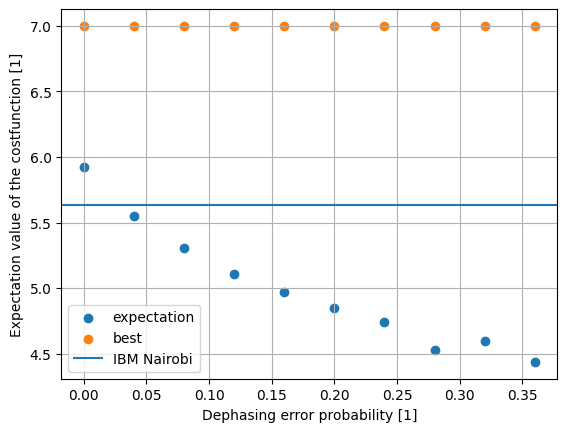

In [9]:
import qiskit_aer.noise
from qiskit.providers.aer.noise.errors import pauli_error



#Noise model from umb nairobi
backend = provider.get_backend('ibm_nairobi')
IBM_NOISE_MODEL = NoiseModel.from_backend(backend)

#Param
SHOTS = 1000
depth = 1
#Study the impact of noise on one graph arteficial noise
probs = np.arange(0,0.4,0.04)


avgs = []
bests = []
best_ratio = []
best_or_second_ratio = []


for prob in probs:
    # Error probabilities
    prob_1 = prob # 1-qubit gate
    prob_2 = prob   # 2-qubit gate

    # Depolarizing quantum errors
    error_1 = qiskit_aer.noise.depolarizing_error(prob_1, 1)
    error_2 = qiskit_aer.noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    CUSTOM_NOISE_MODEL = qiskit_aer.noise.NoiseModel()
    CUSTOM_NOISE_MODEL.add_all_qubit_quantum_error(error_1, ['id', 'rz', 'x', 'sx'])
    CUSTOM_NOISE_MODEL.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    CUSTOM_NOISE_MODEL.add_all_qubit_quantum_error(error_2, ['cx', 'rzz'])

    avg, best, hist = run_experiment(G, depth, SHOTS, CUSTOM_NOISE_MODEL)
    avgs.append(avg)
    bests.append(best[1])

    #How many configurations to the best?
    max_key = '0'
    second_max_key = '0'
    for key in hist.keys():
        if hist[key] > 0:
            if int(key) > int(max_key):
                second_max_key = max_key
                max_key = key
            elif int(key) > int(second_max_key):
                second_max_key = key

    assert(int(max_key) == best[1])
    best_ratio.append(hist[max_key] / SHOTS)
    best_or_second_ratio.append((hist[second_max_key]+hist[max_key]) / SHOTS)   

IBM_avg, IBM_best, IBM_hist = run_experiment(G, depth, SHOTS, IBM_NOISE_MODEL)

plt.figure()
plt.scatter(probs, avgs, label='expectation')
plt.scatter(probs, bests, label='best')
plt.xlabel('Dephasing error probability [1]')
plt.ylabel("Expectation value of the costfunction [1]")
plt.grid('minor')
plt.axhline(IBM_avg, label='IBM Nairobi')
plt.legend()
plt.show()

plt.figure()
plt.scatter(probs, best_ratio, label='Best solution')
plt.scatter(probs, best_or_second_ratio, label='Best or second best')
plt.xlabel('Dephasing error probability [1]')
plt.ylabel('Probability [1]')
plt.legend()
plt.grid('minor')
plt.show()



/home/parzival/EPFL/PH-MA3/QuantumComputing/quantcomp/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


The sampled mean value is M1_sampled = 59.37 



The approximate solution is x* = 0 with C(x*) = 0 



TypeError: printConfig() missing 1 required positional argument: 'x'

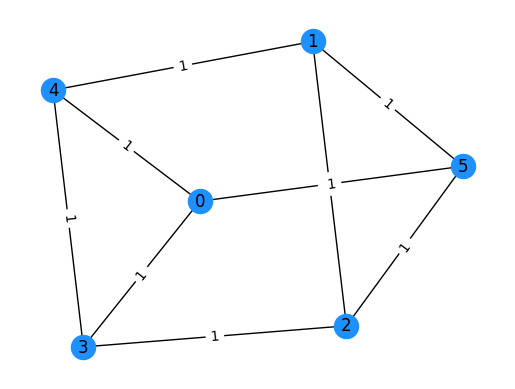

In [42]:
#Output basic circuit example 
def run_experiment_with_plots(G, DEPTH, SHOTS=1000, noise_model=None, METHOD='COBYLA', x0=(1,1), bounds=(-np.pi/2, np.pi/2)):
    BOUNDS = []
    X0 = []
    for k in range(2*DEPTH):
        BOUNDS.append(bounds)
    for k in range(DEPTH):
        X0.append(x0[0])
    for k in range(DEPTH):
        X0.append(x0[1])
    
    #print(X0)
    #print(BOUNDS)
    #BOUNDS =  #, (-3.14, 3.14), (-3.14, 3.14), (-3.14, 3.14), (-3.14, 3.14) ,(-3.14, 3.14), (-3.14, 3.14) ,(-3.14, 3.14)]
    #X0 = [1,1]#,1, 1,0.5,0.5,0.5, 0.5]
    #METHOD = 'COBYLA' #'Nelder-Mead' 
    basis_gates = None
    if noise_model != None:
        basis_gates=noise_model.basis_gates
    optimizerStep = getOptimizerStep(G, noise_model, shots=SHOTS, basis_gates=basis_gates);
    res = optimize.minimize(optimizerStep, x0=X0, method=METHOD, options={'maxiter':3000},  bounds=BOUNDS);
    #print(res)
    x = np.array(res.x)

    gamma = x[0:len(x)//2]
    beta = x[len(x)//2:len(x)]

    results = runQAOAWithParam(gamma, beta, G, noise_model=noise_model, shots=SHOTS, basis_gates=basis_gates)
    avg = expectation(results, 1000, True)
    distr = energyDistribution(results, True)
    best = bestSolution(results, True, True)

    return avg, best, distr
avg, best, dist = run_experiment_with_plots(G, 1, SHOTS, None)

/home/parzival/EPFL/PH-MA3/QuantumComputing/quantcomp/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


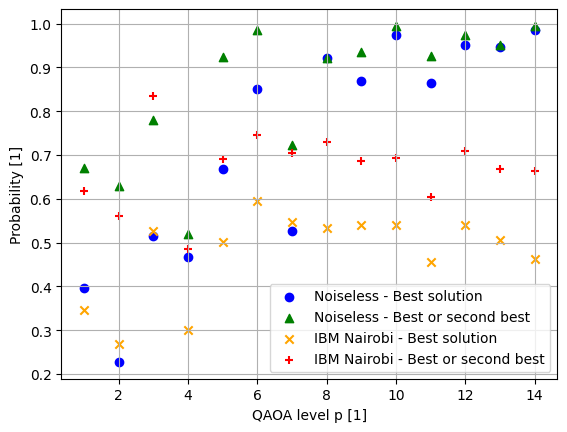

In [15]:
depths = np.arange(1,15,1)
#Study the impact of the depth of the ansatzusing the real noise model
SHOTS = 10000
depths_avg_ibm = []
depths_best_ibm = []
depths_avg_perfect  = []
depths_best_perfect = []

best_ratio_perfect = []
best_or_second_ratio_perfect = []
best_ratio_ibm= []
best_or_second_ratio_ibm = []

for depth in depths:
    avg, best, hist = run_experiment(G, depth, SHOTS, noise_model=None)
    depths_avg_perfect.append(avg)
    depths_best_perfect.append(best[1])

    #How many configurations to the best?
    max_key = '0'
    second_max_key = '0'
    for key in hist.keys():
        if hist[key] > 0:
            if int(key) > int(max_key):
                second_max_key = max_key
                max_key = key
            elif int(key) > int(second_max_key):
                second_max_key = key

    assert(int(max_key) == best[1])
    best_ratio_perfect.append(hist[max_key] / SHOTS)
    best_or_second_ratio_perfect.append((hist[second_max_key]+hist[max_key]) / SHOTS) 
    
    #IBM Noise model
    avg, best, hist = run_experiment(G, depth, SHOTS, IBM_NOISE_MODEL)
    depths_avg_ibm.append(avg)
    depths_best_ibm.append(best[1])

    max_key = '0'
    second_max_key = '0'
    for key in hist.keys():
        if hist[key] > 0:
            if int(key) > int(max_key):
                second_max_key = max_key
                max_key = key
            elif int(key) > int(second_max_key):
                second_max_key = key

    assert(int(max_key) == best[1])
    best_ratio_ibm.append(hist[max_key] / SHOTS)
    best_or_second_ratio_ibm.append((hist[second_max_key]+hist[max_key]) / SHOTS) 
    
plt.figure()
plt.grid('minor')
plt.scatter(depths, depths_avg_ibm, c='orange', marker='x', label='IBM Nairobi')
plt.scatter(depths, depths_avg_perfect, c='blue', marker='o', label='Noiseless')
plt.legend()
plt.xlabel("QAOA level p [1]")
plt.ylabel("Expectation value of the costfunction [1]")
plt.show()

plt.figure()
plt.scatter(depths, best_ratio_perfect, c='blue', marker='o', label='Noiseless - Best solution')
plt.scatter(depths, best_or_second_ratio_perfect, c='green', marker='^', label='Noiseless - Best or second best')
plt.scatter(depths, best_ratio_ibm, c='orange', marker='x', label='IBM Nairobi - Best solution')
plt.scatter(depths, best_or_second_ratio_ibm, c='red', marker='+', label='IBM Nairobi - Best or second best')
plt.xlabel('QAOA level p [1]')
plt.ylabel('Probability [1]')
plt.legend()
plt.grid('minor')
plt.show()

## Evalutate the impact of noise

In [11]:
#Noiseless implementation 
print("=============== Noiseless ============================")
optimizerStep2 = getOptimizerStep(G, noise_model=None, shots=SHOTS, basis_gates=None)
res = optimize.minimize(optimizerStep2, x0=X0, method=METHOD, options={'maxiter':3000}, bounds=BOUNDS)
print(res)
print(expectation(results, 1000, True))


gamma = x[0:len(x)//2]
beta = x[len(x)//2:len(x)]
results = runQAOAWithParam(gamma, beta, G, noise_model=None, shots=SHOTS, basis_gates=None)
plotEnergyDistribution(results)
bestSolution(results, True, True)

=============== Noiseless ============================


NameError: name 'X0' is not defined